# OFFICE HOURS

Report
- Is what we did reasonable?
- Error analysis - explanation for why wrong ones are wrong, with an eye towards generalizability
- confusion matrix, take a closer look at FPs, FNs, etc
- report what didn't work
- dataset balanced?

Try
- Roberta Large
- Val set thru chatGPT, compare with our results
- plot Z scores
- find other training data


In [1]:
!pip install pandas numpy scikit-learn transformers datasets torch accelerate
!pip install -q hf_transfer
#!pip install wandb

  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached transformers-4.57.3-py3-none-any.whl.metadata (43 kB)
  Using cached datasets-4.4.1-py3-none-any.whl.metadata (19 kB)
  Using cached accelerate-1.12.0-py3-none-any.whl.metadata (19 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached scipy-1.16.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached regex-2025.11.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (40 kB)
  Using cached 

In [7]:
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import f1_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
train_raw=pd.read_csv("subtask1/train/eng.csv")

In [8]:
# Dataset class
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        item['labels'] = torch.tensor(int(label), dtype=torch.long)
        return item

In [9]:
# Metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

#ROBERTA BASE HYPERPARAMETER TUNING

In [10]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    "learning_rate": [2e-5, 3e-5],
    "num_train_epochs": [3, 5],
    "per_device_train_batch_size": [32, 64],
}

grid = list(ParameterGrid(param_grid))


In [11]:
from sklearn.model_selection import StratifiedKFold

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)


In [12]:
from sklearn.model_selection import train_test_split

# Clean NaNs just in case
train_raw = train_raw.dropna(subset=['text', 'polarization']).reset_index(drop=True)

# Split train into train/validation
train, test = train_test_split(train_raw, test_size=0.1, random_state=42, stratify=train_raw['polarization'])

In [14]:

# Load RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [15]:
all_results = []

for params in grid:
    f1_scores = []

    for train_idx, val_idx in skf.split(train['text'], train['polarization']):
        # Split the data
        train_fold = train.iloc[train_idx].reset_index(drop=True)
        val_fold = train.iloc[val_idx].reset_index(drop=True)

        # Create datasets
        train_dataset = PolarizationDataset(train_fold['text'].tolist(),
                                            train_fold['polarization'].tolist(),
                                            tokenizer)
        val_dataset = PolarizationDataset(val_fold['text'].tolist(),
                                          val_fold['polarization'].tolist(),
                                          tokenizer)
        # Re-initialize model for each fold
        model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

        # Training arguments
        training_args = TrainingArguments(
            output_dir="./roberta_output",
            num_train_epochs=params['num_train_epochs'],
            learning_rate=params['learning_rate'],
            per_device_train_batch_size=params['per_device_train_batch_size'],
            per_device_eval_batch_size=8,
            eval_strategy="epoch",
            save_strategy="no",
            logging_steps=100,
            disable_tqdm=False,
            report_to=[]
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            data_collator=DataCollatorWithPadding(tokenizer)
        )

        trainer.train()
        eval_results = trainer.evaluate()
        f1_scores.ap
            
        
        
        pend(eval_results['eval_f1_macro'])

    mean_f1 = np.mean(f1_scores)
    print(f"Params: {params}, Mean Macro F1: {mean_f1:.4f}")
    all_results.append((params, mean_f1))


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.457273,0.782139
2,0.489400,0.409655,0.804207
3,0.489400,0.410002,0.816869


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.496802,0.725057
2,0.471200,0.483020,0.785076
3,0.471200,0.513271,0.791157


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.489833,0.760660
2,0.504100,0.417764,0.799807
3,0.504100,0.426755,0.806154


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.452683,0.780481
2,0.507200,0.400458,0.782230
3,0.507200,0.384902,0.828025


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.456822,0.767382
2,0.508400,0.400249,0.791611
3,0.508400,0.402217,0.817551


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Params: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 32}, Mean Macro F1: 0.8120


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.503490,0.711841
2,No log,0.416289,0.804036
3,No log,0.404309,0.804614


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.524461,0.719426
2,No log,0.513398,0.747631
3,No log,0.467463,0.769009


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.506457,0.748285
2,No log,0.411621,0.800556
3,No log,0.401831,0.801244


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.519659,0.662270
2,No log,0.429592,0.777693
3,No log,0.402160,0.814265


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.501223,0.673048
2,No log,0.410539,0.803627
3,No log,0.402727,0.811897


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Params: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 64}, Mean Macro F1: 0.8002


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.415704,0.794077
2,0.486200,0.417956,0.800135
3,0.486200,0.466797,0.804521
4,0.297000,0.499197,0.819431
5,0.170500,0.524231,0.809364


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.558446,0.673670
2,0.481000,0.476924,0.771780
3,0.481000,0.526762,0.779650
4,0.268300,0.691019,0.751290
5,0.141700,0.704131,0.770899


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.414803,0.787689
2,0.493300,0.409684,0.805788
3,0.493300,0.474198,0.781005
4,0.291500,0.470606,0.810607
5,0.168500,0.528918,0.804879


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.457407,0.788620
2,0.511100,0.406975,0.742328
3,0.511100,0.394250,0.822901
4,0.314700,0.446521,0.816272
5,0.178000,0.490028,0.820646


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.430772,0.783831
2,0.494200,0.412934,0.810256
3,0.494200,0.397856,0.828915
4,0.304700,0.477817,0.823155
5,0.197300,0.478350,0.820022


Params: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 32}, Mean Macro F1: 0.8052


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.472881,0.773528
2,No log,0.391727,0.818262
3,No log,0.400496,0.812831
4,0.436500,0.414295,0.820841
5,0.436500,0.422246,0.817217


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.502570,0.753349
2,No log,0.470818,0.765429
3,No log,0.496546,0.769424
4,0.449800,0.510439,0.774585
5,0.449800,0.517082,0.777827


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.486240,0.736186
2,No log,0.402526,0.803150
3,No log,0.405801,0.802621
4,0.438300,0.414250,0.813797
5,0.438300,0.419368,0.818157


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.517572,0.677852
2,No log,0.390186,0.807144
3,No log,0.394511,0.808892
4,0.467700,0.391212,0.822660
5,0.467700,0.393937,0.820293


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.462849,0.746512
2,No log,0.381389,0.811829
3,No log,0.378767,0.825617
4,0.445400,0.430442,0.816014
5,0.445400,0.412663,0.815158


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Params: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 64}, Mean Macro F1: 0.8097


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.424182,0.800861
2,0.475500,0.387130,0.805788
3,0.475500,0.405483,0.816869


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.465815,0.742161
2,0.449600,0.510962,0.786348
3,0.449600,0.565075,0.775710


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.513009,0.772211
2,0.490200,0.404649,0.825076
3,0.490200,0.413718,0.822893


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.449621,0.781325
2,0.470700,0.386884,0.786767
3,0.470700,0.410790,0.823964


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.412838,0.777871
2,0.483300,0.408274,0.797342
3,0.483300,0.421654,0.822836


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Params: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 32}, Mean Macro F1: 0.8125


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.436719,0.792955
2,No log,0.400326,0.812773
3,No log,0.399940,0.805012


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.464286,0.762761
2,No log,0.487930,0.775166
3,No log,0.486648,0.777337


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.430623,0.774476
2,No log,0.407829,0.794671
3,No log,0.412313,0.783536


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.493838,0.710716
2,No log,0.398418,0.789612
3,No log,0.397236,0.803149


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.526179,0.686645
2,No log,0.398235,0.801796
3,No log,0.386985,0.813154


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Params: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 64}, Mean Macro F1: 0.7964


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.500784,0.782704
2,0.480100,0.431870,0.807110
3,0.480100,0.462531,0.802233
4,0.289800,0.525691,0.819029
5,0.135100,0.634399,0.801106


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.468066,0.755243
2,0.462200,0.489764,0.752609
3,0.462200,0.541384,0.771224
4,0.256200,0.781122,0.762363
5,0.119800,0.839906,0.763078


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.419968,0.805226
2,0.484000,0.406261,0.803638
3,0.484000,0.454398,0.820267
4,0.271600,0.545438,0.799807
5,0.138700,0.635085,0.794224


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.473324,0.772251
2,0.464700,0.402984,0.768332
3,0.464700,0.445842,0.807147
4,0.284700,0.485528,0.807893
5,0.137900,0.559501,0.812768


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.428867,0.774889
2,0.497700,0.420902,0.803429
3,0.497700,0.398250,0.825358
4,0.298400,0.471849,0.820557
5,0.181000,0.497457,0.831322


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Params: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 32}, Mean Macro F1: 0.8005


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.464757,0.767342
2,No log,0.416276,0.794077
3,No log,0.412625,0.813551
4,0.409800,0.448960,0.805401
5,0.409800,0.478261,0.811773


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.511472,0.700497
2,No log,0.459173,0.759241
3,No log,0.524973,0.781767
4,0.410500,0.540229,0.769820
5,0.410500,0.578530,0.780730


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.431276,0.788013
2,No log,0.406887,0.808213
3,No log,0.428446,0.787909
4,0.419100,0.435616,0.796605
5,0.419100,0.454290,0.806154


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.496930,0.751046
2,No log,0.388891,0.814776
3,No log,0.428775,0.773060
4,0.470200,0.409630,0.824677
5,0.470200,0.417389,0.814618


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,No log,0.475704,0.756434
2,No log,0.417056,0.800771
3,No log,0.392402,0.819589
4,0.415900,0.439453,0.814292
5,0.415900,0.448669,0.820646


Params: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 64}, Mean Macro F1: 0.8068


In [16]:
all_results

[({'learning_rate': 2e-05,
   'num_train_epochs': 3,
   'per_device_train_batch_size': 32},
  np.float64(0.8119512790968132)),
 ({'learning_rate': 2e-05,
   'num_train_epochs': 3,
   'per_device_train_batch_size': 64},
  np.float64(0.8002057515120693)),
 ({'learning_rate': 2e-05,
   'num_train_epochs': 5,
   'per_device_train_batch_size': 32},
  np.float64(0.805162112594948)),
 ({'learning_rate': 2e-05,
   'num_train_epochs': 5,
   'per_device_train_batch_size': 64},
  np.float64(0.8097304769336559)),
 ({'learning_rate': 3e-05,
   'num_train_epochs': 3,
   'per_device_train_batch_size': 32},
  np.float64(0.8124544604591455)),
 ({'learning_rate': 3e-05,
   'num_train_epochs': 3,
   'per_device_train_batch_size': 64},
  np.float64(0.7964374379985557)),
 ({'learning_rate': 3e-05,
   'num_train_epochs': 5,
   'per_device_train_batch_size': 32},
  np.float64(0.8004992817894525)),
 ({'learning_rate': 3e-05,
   'num_train_epochs': 5,
   'per_device_train_batch_size': 64},
  np.float64(0.80678

In [17]:
results_df=pd.DataFrame(all_results)
results_df.columns=['hps', 'f2_avg']

In [18]:
results_df[results_df.f2_avg==results_df.f2_avg.max()].hps.values

array([{'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 32}],
      dtype=object)

best hps for base Roberta: 3e-5 learning rate, 3 epochs, 32 train batch size

In [19]:
test_dataset = PolarizationDataset(test['text'].tolist(), test['polarization'].tolist(), tokenizer)


In [20]:


best_model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

best_args = TrainingArguments(
    output_dir="./best_model",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    num_train_epochs=3,
    eval_strategy="no",
    save_strategy='no',
    report_to=[]
)

best_trainer = Trainer(
    model=best_model,
    args=best_args,
    train_dataset=train_dataset,
    eval_dataset=None,  # or None if you’ve already validated
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer)
)

best_trainer.train()
best_trainer.save_model("./roberta_best_model")
predictions = best_trainer.predict(test_dataset)



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


In [21]:
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids
print(list(zip(test['text'][:5], y_pred[:5])))


[('Pope Francis Condemns Reported Israeli Sniper Attack', np.int64(0)), ('The New York Times supports apartheid, ethnic cleansing, and genocide.', np.int64(1)), ('Based Ryukishi acknowledging Japans war crimes', np.int64(0)), ('Early Voting being today fuck niggas!', np.int64(1)), ('At Sunday Vigil, More Than 1000 Mourn Victims of Hamas', np.int64(0))]


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  # or 'macro' for both classes equally
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Accuracy:  0.8172
Precision: 0.8062
Recall:    0.7995
F1 Score:  0.8025


In [24]:
!pip install matplotlib
import matplotlib.pyplot as plt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 46.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 50.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [matplotlib]5 [matplotlib]


In [25]:
compute_metrics(predictions)

{'f1_macro': 0.8025114670275961}

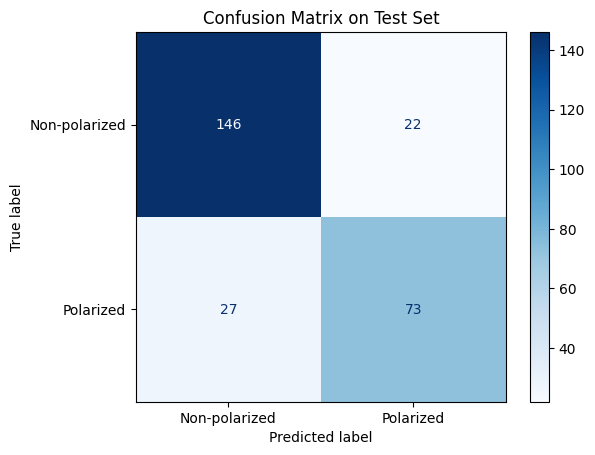

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-polarized", "Polarized"]
)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix on Test Set")
plt.show()


In [28]:
from torch.utils.data import Dataset

class UnlabeledDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        # return tensors without labels
        return {key: val.squeeze() for key, val in encoding.items()}


In [27]:
dev=pd.read_csv('dev_eng_with_predictions.csv')
dev_test = PolarizationDataset(dev['text'].tolist(), dev['polarization_pred'].tolist(), tokenizer)



In [29]:
dev_pred = best_trainer.predict(dev_test)

In [30]:
y_pred_dev = np.argmax(dev_pred.predictions, axis=1)
y_gpt = dev_pred.label_ids
print(list(zip(dev['text'][:5], y_pred_dev[:5])))


[('God is with Ukraine and Zelensky', np.int64(0)), ('4 Dems, 2 Republicans Luzerne County Council seatsDallas', np.int64(0)), ('Abuse Survivor Recounts Her Struggles at YWCA Event', np.int64(0)), ('After Rwanda, another deportation camp disaster', np.int64(0)), ('Another plea in Trump election interference probe', np.int64(0))]


In [31]:
accuracy = accuracy_score(y_gpt, y_pred_dev)
precision = precision_score(y_gpt, y_pred_dev, average='macro')  # or 'macro' for both classes equally
recall = recall_score(y_gpt, y_pred_dev, average='macro')
f1 = f1_score(y_gpt, y_pred_dev, average='macro')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.8195
Precision: 0.7876
Recall:    0.8020
F1 Score:  0.7938


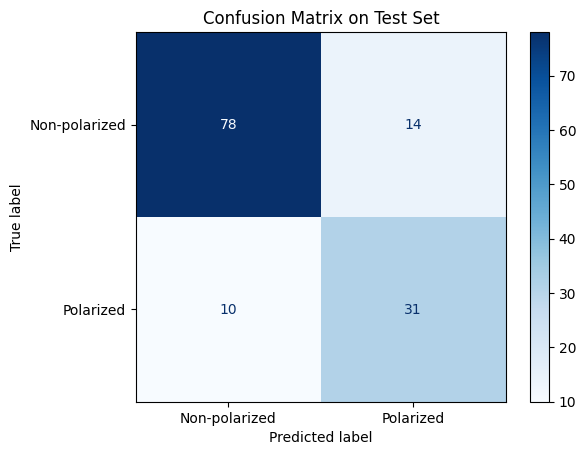

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_gpt, y_pred_dev)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-polarized", "Polarized"]
)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix on Test Set")
plt.show()


# ROBERTA LARGE

In [39]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    "learning_rate": [1e-5, 2e-5],
    "num_train_epochs": [3, 5],
    "per_device_train_batch_size": [8, 16]
}

grid = list(ParameterGrid(param_grid))


In [40]:
from sklearn.model_selection import StratifiedKFold

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)


In [41]:

# Load RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-large')

In [42]:
from sklearn.model_selection import train_test_split

# Clean NaNs just in case
train_raw = train_raw.dropna(subset=['text', 'polarization']).reset_index(drop=True)

# Split train into train/validation
train, test = train_test_split(train_raw, test_size=0.1, random_state=42, stratify=train_raw['polarization'])

In [44]:
all_results_large = []

for params in grid:
    f1_scores = []

    for train_idx, val_idx in skf.split(train['text'], train['polarization']):
        # Split the data
        train_fold = train.iloc[train_idx].reset_index(drop=True)
        val_fold = train.iloc[val_idx].reset_index(drop=True)

        # Create datasets
        train_dataset = PolarizationDataset(train_fold['text'].tolist(),
                                            train_fold['polarization'].tolist(),
                                            tokenizer)
        val_dataset = PolarizationDataset(val_fold['text'].tolist(),
                                          val_fold['polarization'].tolist(),
                                          tokenizer)
        # Re-initialize model for each fold
        model = AutoModelForSequenceClassification.from_pretrained('roberta-large', num_labels=2)

        # Training arguments
        training_args = TrainingArguments(
            output_dir="./roberta_output",
            num_train_epochs=params['num_train_epochs'],
            learning_rate=params['learning_rate'],
            per_device_train_batch_size=8,
            #per_device_train_batch_size=params['per_device_train_batch_size'],
            per_device_eval_batch_size=8,
            eval_strategy="epoch",
            save_strategy="no",
            logging_steps=100,
            disable_tqdm=False,
            report_to=[]
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            data_collator=DataCollatorWithPadding(tokenizer)
        )

        trainer.train()
        eval_results = trainer.evaluate()
        f1_scores.append(eval_results['eval_f1_macro'])

    mean_f1 = np.mean(f1_scores)
    print(f"Params: {params}, Mean Macro F1: {mean_f1:.4f}")
    all_results_large.append((params, mean_f1))

results_df_roberta_large=pd.DataFrame(all_results_large)
results_df_roberta_large.columns=['hps', 'f2_avg']
results_df_roberta_large.to_csv('results_df_roberta_large.csv')


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.511200,0.455018,0.807579
2,0.400700,0.467458,0.804614
3,0.351000,0.677731,0.806873


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.544000,0.486257,0.789670
2,0.415900,0.545809,0.782660
3,0.394000,0.720163,0.782763


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.529600,0.647845,0.792092
2,0.410300,0.455669,0.823264
3,0.335700,0.756734,0.810495


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.490900,0.417754,0.786932
2,0.413800,0.449260,0.778270
3,0.398200,0.770681,0.809524


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.676900,0.613538,0.402786
2,0.599600,0.485367,0.788193
3,0.438200,0.438593,0.818767


Params: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8}, Mean Macro F1: 0.8057


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.509000,0.426207,0.800940
2,0.387600,0.445577,0.805401
3,0.347000,0.768405,0.811393


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.544000,0.486257,0.789670
2,0.415900,0.545809,0.782660
3,0.394000,0.720163,0.782763


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.529600,0.647845,0.792092
2,0.410300,0.455669,0.823264
3,0.335700,0.756734,0.810495


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.490900,0.417754,0.786932
2,0.413800,0.449260,0.778270
3,0.398200,0.770681,0.809524


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.676900,0.613538,0.402786
2,0.599600,0.485367,0.788193
3,0.438200,0.438593,0.818767


Params: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16}, Mean Macro F1: 0.8066


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.585900,0.478440,0.762545
2,0.441100,0.468984,0.799428
3,0.380600,0.628607,0.799455
4,0.244500,0.902746,0.798139
5,0.149300,1.045590,0.788324


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.505000,0.433240,0.781254
2,0.390900,0.527454,0.784245
3,0.342100,1.023484,0.797819
4,0.192400,1.116501,0.799807
5,0.119000,1.269097,0.797394


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.488500,0.527908,0.794644
2,0.420800,0.528699,0.813609
3,0.360600,0.823045,0.812166
4,0.198700,0.932863,0.819795
5,0.144500,0.984125,0.826206


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.513200,0.503028,0.777680
2,0.491600,0.409342,0.808854
3,0.340900,0.651452,0.805887
4,0.306800,0.739288,0.816787
5,0.204600,0.881389,0.818005


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.493100,0.459877,0.799434
2,0.413700,0.438406,0.835470
3,0.384000,0.863612,0.806475
4,0.215200,0.878695,0.835011
5,0.130000,1.013090,0.828716


Params: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8}, Mean Macro F1: 0.8117


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.565800,0.423531,0.793085
2,0.387300,0.537708,0.800556
3,0.390700,0.661427,0.820883
4,0.286100,0.856523,0.821230
5,0.192900,0.995237,0.803789


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.505000,0.433240,0.781254
2,0.390900,0.527454,0.784245
3,0.342100,1.023484,0.797819
4,0.192400,1.116501,0.799807
5,0.119000,1.269097,0.797394


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.488500,0.527908,0.794644
2,0.420800,0.528699,0.813609
3,0.360600,0.823045,0.812166
4,0.198700,0.932863,0.819795
5,0.144500,0.984125,0.826206


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.513200,0.503028,0.777680
2,0.491600,0.409342,0.808854
3,0.340900,0.651452,0.805887
4,0.306800,0.739288,0.816787
5,0.204600,0.881389,0.818005


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.493100,0.459877,0.799434
2,0.413700,0.438406,0.835470
3,0.384000,0.863612,0.806475
4,0.215200,0.878695,0.835011
5,0.130000,1.013090,0.828716


Params: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16}, Mean Macro F1: 0.8148


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.694500,0.618729,0.675314
2,0.634500,0.663148,0.384419
3,0.598700,0.589628,0.384419


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.486600,0.474960,0.765961
2,0.380300,0.666933,0.758986
3,0.297400,0.868937,0.786714


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.580600,0.621913,0.772195
2,0.461400,0.471791,0.791430
3,0.344800,0.644470,0.806203


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.523900,0.396978,0.809621
2,0.412600,0.517636,0.828716
3,0.265900,0.700106,0.824466


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.543500,0.439815,0.806955
2,0.435700,0.469810,0.834795
3,0.369000,0.634808,0.837167


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Params: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8}, Mean Macro F1: 0.7278


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.537800,0.476383,0.776855
2,0.434000,0.584620,0.783400
3,0.371000,0.788267,0.801798


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.486600,0.474960,0.765961
2,0.380300,0.666933,0.758986
3,0.297400,0.868937,0.786714


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.580600,0.621913,0.772195
2,0.461400,0.471791,0.791430
3,0.344800,0.644470,0.806203


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.523900,0.396978,0.809621
2,0.412600,0.517636,0.828716
3,0.265900,0.700106,0.824466


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.543500,0.439815,0.806955
2,0.435700,0.469810,0.834795
3,0.369000,0.634808,0.837167


Params: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16}, Mean Macro F1: 0.8113


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.630900,0.629040,0.384419
2,0.466600,0.526219,0.767052
3,0.419000,0.637193,0.810832
4,0.285500,0.950166,0.764393
5,0.198600,0.968229,0.781068


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.627500,0.536658,0.773187
2,0.426700,0.560973,0.786127
3,0.375300,0.937344,0.782208
4,0.202800,1.151655,0.767004
5,0.161300,1.233811,0.773415


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.526700,0.621340,0.813424
2,0.453900,0.502380,0.809394
3,0.355300,0.945103,0.811596
4,0.176100,0.948629,0.805106
5,0.128800,0.887942,0.830588


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.661700,0.661379,0.384910
2,0.671900,0.660925,0.384910
3,0.660500,0.668911,0.384910
4,0.658900,0.644297,0.481338
5,0.637400,0.643427,0.469876


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.692100,0.661666,0.384910
2,0.689600,0.668901,0.384910
3,0.657300,0.688214,0.384910
4,0.667800,0.669271,0.384910
5,0.667300,0.758208,0.384910


Params: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8}, Mean Macro F1: 0.6480


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.673200,0.663989,0.384419
2,0.675300,0.665898,0.384419
3,0.666700,0.667076,0.384419
4,0.672500,0.664681,0.384419
5,0.662000,0.657029,0.384419


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.627500,0.536658,0.773187
2,0.426700,0.560973,0.786127
3,0.375300,0.937344,0.782208
4,0.202800,1.151655,0.767004
5,0.161300,1.233811,0.773415


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.526700,0.621340,0.813424
2,0.453900,0.502380,0.809394
3,0.355300,0.945103,0.811596
4,0.176100,0.948629,0.805106
5,0.128800,0.887942,0.830588


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.661700,0.661379,0.384910
2,0.671900,0.660925,0.384910
3,0.660500,0.668911,0.384910
4,0.658900,0.644297,0.481338
5,0.637400,0.643427,0.469876


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.692100,0.661666,0.384910
2,0.689600,0.668901,0.384910
3,0.657300,0.688214,0.384910
4,0.667800,0.669271,0.384910
5,0.667300,0.758208,0.384910


Params: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16}, Mean Macro F1: 0.5686


In [45]:
all_results_large_df=pd.DataFrame(all_results_large)
all_results_large_df.columns=['hps','f2_avg']
all_results_large_df[all_results_large_df.f2_avg==all_results_large_df.f2_avg.max()].hps.values

array([{'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16}],
      dtype=object)

In [46]:


best_model_rl = AutoModelForSequenceClassification.from_pretrained('roberta-large', num_labels=2)

best_args_rl = TrainingArguments(
    output_dir="./best_model_rl",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    num_train_epochs=5,
    eval_strategy="no",
    save_strategy='no',
    report_to=[]
)

best_trainer_rl = Trainer(
    model=best_model_rl,
    args=best_args_rl,
    train_dataset=train_dataset,
    eval_dataset=None,  # or None if you’ve already validated
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer)
)

best_trainer_rl.train()
best_trainer_rl.save_model("./roberta_large_best_model")
predictions_rl = best_trainer_rl.predict(test_dataset)



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.381900


In [47]:
y_pred_rl = np.argmax(predictions_rl.predictions, axis=1)
y_true_rl = predictions_rl.label_ids



In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_rl = accuracy_score(y_true_rl, y_pred_rl)
precision_rl = precision_score(y_true_rl, y_pred_rl, average='macro')  # or 'macro' for both classes equally
recall_rl = recall_score(y_true_rl, y_pred_rl, average='macro')
f1_rl = f1_score(y_true_rl, y_pred_rl, average='macro')

print(f"Accuracy:  {accuracy_rl:.4f}")
print(f"Precision: {precision_rl:.4f}")
print(f"Recall:    {recall_rl:.4f}")
print(f"F1 Score:  {f1_rl:.4f}")


Accuracy:  0.8433
Precision: 0.8381
Recall:    0.8224
F1 Score:  0.8288


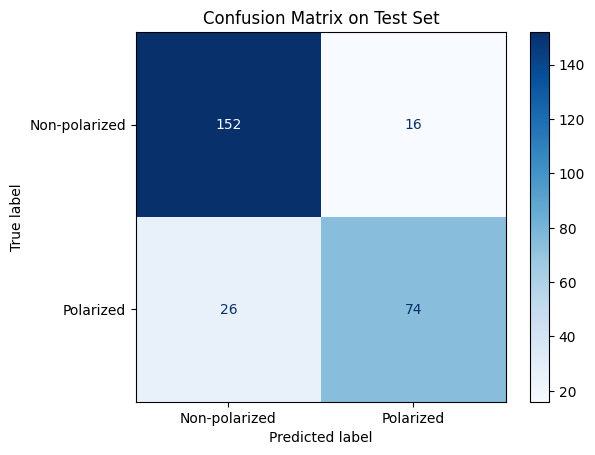

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_rl = confusion_matrix(y_true_rl, y_pred_rl)
disp_rl = ConfusionMatrixDisplay(
    confusion_matrix=cm_rl,
    display_labels=["Non-polarized", "Polarized"]
)
disp_rl.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix on Test Set")
plt.show()


Accuracy:  0.8120
Precision: 0.7804
Recall:    0.8033
F1 Score:  0.7889


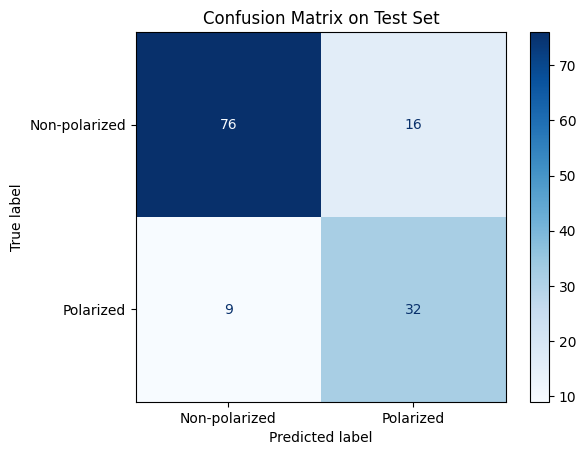

In [50]:
dev_pred_rl = best_trainer_rl.predict(dev_test)
y_pred_dev_rl = np.argmax(dev_pred_rl.predictions, axis=1)
y_gpt_rl = dev_pred_rl.label_ids

accuracy_gpt_rl = accuracy_score(y_gpt_rl, y_pred_dev_rl)
precision_gpt_rl  = precision_score(y_gpt_rl, y_pred_dev_rl, average='macro')  # or 'macro' for both classes equally
recall_gpt_rl  = recall_score(y_gpt_rl, y_pred_dev_rl, average='macro')
f1_gpt_rl  = f1_score(y_gpt_rl, y_pred_dev_rl, average='macro')

print(f"Accuracy:  {accuracy_gpt_rl :.4f}")
print(f"Precision: {precision_gpt_rl :.4f}")
print(f"Recall:    {recall_gpt_rl :.4f}")
print(f"F1 Score:  {f1_gpt_rl :.4f}")


cm_gpt_rl = confusion_matrix(y_gpt_rl, y_pred_dev_rl)
disp_gpt_rl = ConfusionMatrixDisplay(
    confusion_matrix=cm_gpt_rl,
    display_labels=["Non-polarized", "Polarized"]
)
disp_gpt_rl.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix on Test Set")
plt.show()


# INITIAL BASE ROBERTA AND BASE BERT BELOW

In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)

# Load the training and validation data
train = pd.read_csv('train_eng.csv')


from sklearn.model_selection import train_test_split

# Clean NaNs just in case
train = train.dropna(subset=['text', 'polarization']).reset_index(drop=True)

# Split train into train/validation
train_df, test_df = train_test_split(train, test_size=0.1, random_state=42, stratify=train['polarization'])

'''# Load the training and validation data for subtask 1
train = pd.read_csv('train_eng.csv')
#train = pd.read_csv('subtask1/train/eng.csv')
#val = pd.read_csv('subtask1/train/eng.csv')
val = pd.read_csv('train_eng.csv')'''

# Dataset class
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        item['labels'] = torch.tensor(int(label), dtype=torch.long)
        return item


# Load RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# Create datasets
train_dataset = PolarizationDataset(train['text'].tolist(), train['polarization'].tolist(), tokenizer)
val_dataset = PolarizationDataset(val['text'].tolist(), val['polarization'].tolist(), tokenizer)

# Load RoBERTa model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

# Training arguments
training_args = TrainingArguments(
    output_dir="./roberta_output",
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    disable_tqdm=False,
    report_to=[]
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer)
)

# Train
trainer.train()

# Evaluate
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set: {eval_results['eval_f1_macro']}")


In [ ]:
train[train==val]

In [ ]:
import pandas as pd

from sklearn.metrics import recall_score, precision_score, f1_score
import numpy as np

import torch

from sklearn.metrics import f1_score

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from torch.utils.data import Dataset

# Load the training and validation data for subtask 1
train = pd.read_csv('train_eng.csv')
#train = pd.read_csv('subtask1/train/eng.csv')
#val = pd.read_csv('subtask1/train/eng.csv')
val = pd.read_csv('train_eng.csv')

train.head()

# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
  def __init__(self,texts,labels,tokenizer,max_length =128):
    self.texts=texts
    self.labels=labels
    self.tokenizer= tokenizer
    self.max_length = max_length # Store max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self,idx):
    text=self.texts[idx]
    label=self.labels[idx]
    encoding=self.tokenizer(text,truncation=True,padding=False,max_length=self.max_length,return_tensors='pt')

    # Ensure consistent tensor conversion for all items
    item = {key: encoding[key].squeeze() for key in encoding.keys()}
    item['labels'] = torch.tensor(label, dtype=torch.long)
    return item

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
train_dataset = PolarizationDataset(train['text'].tolist(), train['polarization'].tolist(), tokenizer)
val_dataset = PolarizationDataset(val['text'].tolist(), val['polarization'].tolist(), tokenizer)

# Load the model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

# Define training arguments
training_args = TrainingArguments(
        output_dir=f"./",
        num_train_epochs=3,
        learning_rate=2e-5,
        per_device_train_batch_size=64,
        per_device_eval_batch_size=8,
        eval_strategy="epoch",
        save_strategy="no",
        logging_steps=100,
        disable_tqdm=False,
        report_to=[]
    )


# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
    data_collator=DataCollatorWithPadding(tokenizer) # Data collator for dynamic padding
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set: {eval_results['eval_f1_macro']}")